### Data available here:
https://www.kaggle.com/c/dog-breed-identification/data

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms, datasets, models

from scipy.stats import entropy, ks_2samp
from scipy.special import kl_div

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import copy

In [2]:
np.random.seed(0)

In [3]:
INPUT_SIZE = 224
NUM_CLASSES = 16
data_dir = 'data/dog_breed/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [4]:
target_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES*2).index)
selected_breed_list_both = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES*2).index)
selected_breed_list_two = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES*2)[NUM_CLASSES:].index)
selected_breed_list_one = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)

labels = labels[labels['breed'].isin(target_breed_list)]
labels['target'] = np.where(labels.breed.isin(selected_breed_list_one), 1, 2)
# labels['target'] = np.where(labels.breed.isin(selected_breed_list_two), 2, 1)
# labels['target'] = np.where(labels.breed.isin(selected_breed_list_both), 3, 0)
# labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(2653, 33) (663, 33)


In [5]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].as_matrix().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [20]:
len(train_both_indices)

2653

In [14]:
random_seed= 42
shuffle_dataset = True

## Use only the dog breeds in selected_breeds as training examples
train_one_indices = []
train_two_indices = []
train_both_indices = []
i = 0
for idx,row in train.iterrows():
    if row[1:].sum() == 1.0:
        train_one_indices.append(i)
    elif row[1:].sum() == 2.0:
        train_two_indices.append(i)
    if row[1:].sum() > 0:
        train_both_indices.append(i)
    i+=1
# train_indices = train[train.iloc[:,1:].astype(bool).sum(axis=1) == 1].index

# Creating PT data samplers and loaders:
train_one_sampler = SubsetRandomSampler(train_one_indices)
train_two_sampler = SubsetRandomSampler(train_two_indices)
train_both_sampler = SubsetRandomSampler(train_both_indices)
# valid_sampler = SubsetRandomSampler(val_indices)
# samplers = {'train':train_sampler, 'val':valid_sampler}


normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Scale(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir+'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir+'train/', transform=ds_trans)

train_dl_one = DataLoader(train_ds, batch_size=4, sampler=train_one_sampler, num_workers=4)
train_dl_two = DataLoader(train_ds, batch_size=4, sampler=train_two_sampler, num_workers=4)
train_dl_both = DataLoader(train_ds, batch_size=4, sampler=train_both_sampler, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

In [25]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224]) torch.Size([4])


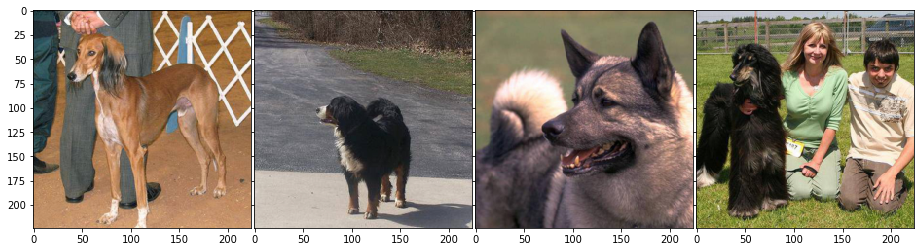

In [27]:
img, label = next(iter(train_dl_both))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

## Train a transfer learning model

In [28]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    writer = SummaryWriter('runs/') 

    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].sampler), 
                     'valid': len(dataloders['valid'].sampler)}

    i = 0
    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    ## Tensorboard
                    writer.add_histogram('distribution centers/resnet2', model.fc.weight.cpu().detach().numpy(), i)
                    i+=1
                
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
                
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    writer.close()
    model.load_state_dict(best_model_wts)
    return model

In [30]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl_both))

resnet = resnet.cuda()
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   

outputs = resnet(inputs)
outputs.size()

/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


torch.Size([4, 1000])

In [42]:
resnet = models.resnet50(pretrained=True)
# freeze all model parameters
# for param in resnet.parameters():
#     param.requires_grad = False

# new final layer with 16 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 32)

resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl_both, 'valid':valid_dl}

In [43]:
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be rem

Epoch [0/9] train loss: 0.4812 acc: 0.5096 valid loss: 0.1124 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be rem

Epoch [1/9] train loss: 0.2341 acc: 0.7512 valid loss: 0.0685 acc: 0.9261


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be rem

Epoch [2/9] train loss: 0.1903 acc: 0.7836 valid loss: 0.0633 acc: 0.9246


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be rem

Epoch [3/9] train loss: 0.1600 acc: 0.8221 valid loss: 0.0651 acc: 0.9216


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be rem

Epoch [4/9] train loss: 0.1539 acc: 0.8153 valid loss: 0.0548 acc: 0.9382


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be rem

Epoch [5/9] train loss: 0.1417 acc: 0.8296 valid loss: 0.0582 acc: 0.9291


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be rem

Epoch [6/9] train loss: 0.1233 acc: 0.8594 valid loss: 0.0478 acc: 0.9427


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be rem

Epoch [7/9] train loss: 0.1159 acc: 0.8666 valid loss: 0.0456 acc: 0.9321


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be rem

Epoch [8/9] train loss: 0.1224 acc: 0.8598 valid loss: 0.0520 acc: 0.9231


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be rem

Epoch [9/9] train loss: 0.1150 acc: 0.8865 valid loss: 0.0482 acc: 0.9336
Best val Acc: 0.942685
Training time:  11.095601 minutes


In [44]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
W1010 18:10:19.354885 140610319845120 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1010 18:10:19.370342 140610319845120 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

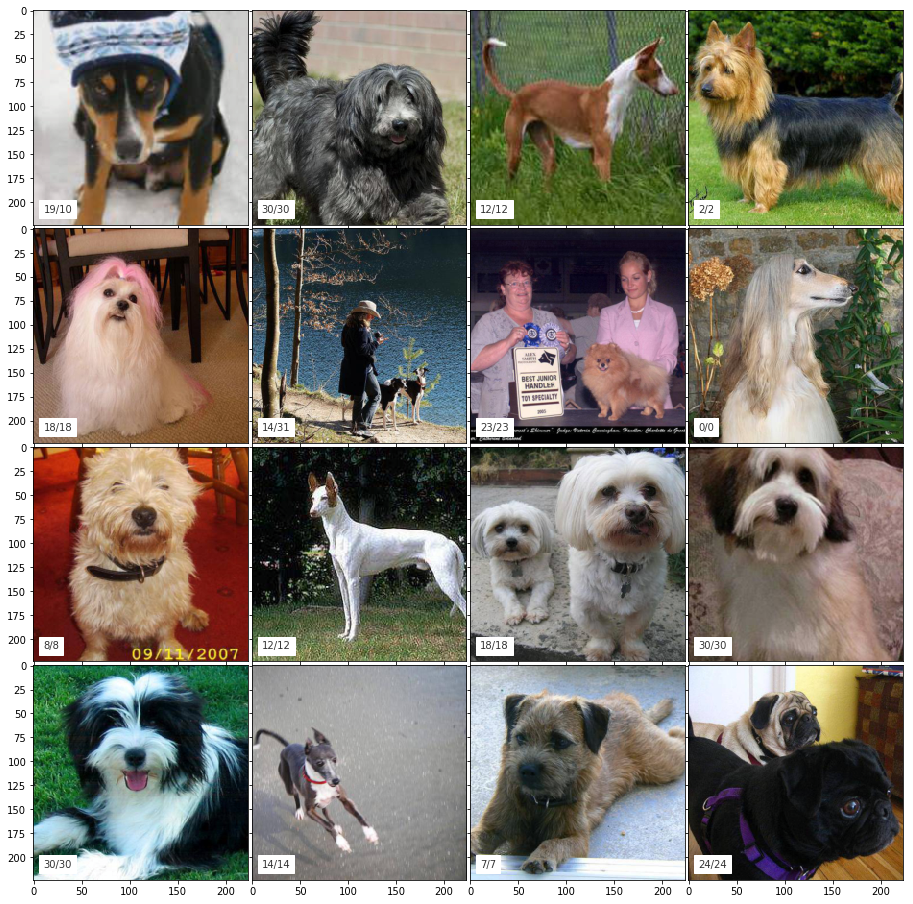

In [45]:
visualize_model(dloaders, resnet)

### Save models

In [35]:
# train.to_csv('data/dog_breed/train.pt')
# valid.to_csv('data/dog_breed/valid.pt')

In [46]:
PATH = 'data/dog_breed/resnet3.pt'
torch.save({'model_state_dict': resnet.state_dict()}, PATH)

## Investigation of layers

In [46]:
for p in resnet.named_parameters():
    print(p[0])

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

### Load 3 models -> resnet 1 and resnet 2 trained on discrete data and resnet 3 trained on all data

In [48]:
dldr = []
resnets = []

for i in range(3):
    ## Load the models
    resnet = models.resnet50(pretrained=True)
    # freeze all model parameters
    # for param in resnet.parameters():
    #     param.requires_grad = False

    # new final layer with 16 classes
    num_ftrs = resnet.fc.in_features
    resnet.fc = torch.nn.Linear(num_ftrs, 32)
        
    resnet = resnet.cuda()

    PATH = 'data/dog_breed/resnet'+str(i+1)+'.pt'
    checkpoint = torch.load(PATH)
    resnet.load_state_dict(checkpoint['model_state_dict'])
    resnets.append(resnet)

    

train = pd.read_csv('data/dog_breed/train.pt', index_col=0)
valid = pd.read_csv('data/dog_breed/valid.pt', index_col=0)
print(train.shape, valid.shape)
        
random_seed= 42
shuffle_dataset = True

## Use only the dog breeds in selected_breeds as training examples
train_one_indices = []
train_two_indices = []
train_both_indices = []
i = 0
for idx,row in train.iterrows():
    if row[1:].sum() == 1.0:
        train_one_indices.append(i)
    elif row[1:].sum() == 2.0:
        train_two_indices.append(i)
    if row[1:].sum() > 0:
        train_both_indices.append(i)
    i+=1
# train_indices = train[train.iloc[:,1:].astype(bool).sum(axis=1) == 1].index

# Creating PT data samplers and loaders:
train_one_sampler = SubsetRandomSampler(train_one_indices)
train_two_sampler = SubsetRandomSampler(train_two_indices)
train_both_sampler = SubsetRandomSampler(train_both_indices)
# valid_sampler = SubsetRandomSampler(val_indices)
# samplers = {'train':train_sampler, 'val':valid_sampler}


normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Scale(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir+'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir+'train/', transform=ds_trans)

train_dl_one = DataLoader(train_ds, batch_size=4, sampler=train_one_sampler, num_workers=4)
train_dl_two = DataLoader(train_ds, batch_size=4, sampler=train_two_sampler, num_workers=4)
train_dl_both = DataLoader(train_ds, batch_size=4, sampler=train_both_sampler, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)
    
resnet1 = resnets[0]
dloaders1 = {'train':train_dl_one, 'valid':valid_dl}

resnet2 = resnets[1]
dloaders2 = {'train':train_dl_two, 'valid':valid_dl}

resnet3 = resnets[2]
dloaders3 = {'train':train_dl_both, 'valid':valid_dl}

(2653, 33) (663, 33)


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


## compare final layer distribution

In [49]:
first = resnet1.fc.weight.cpu().detach().numpy()
second = resnet2.fc.weight.cpu().detach().numpy()
third = resnet3.fc.weight.cpu().detach().numpy()

In [70]:
ks_2samp(first.flatten(), second.flatten())

Ks_2sampResult(statistic=0.007049560546875, pvalue=0.07667745555597658)

In [54]:
ks_2samp(first.flatten(), third.flatten())

Ks_2sampResult(statistic=0.1300201416015625, pvalue=0.0)

In [55]:
x = np.random.normal(0, 1, first.flatten().shape)
y = np.random.normal(0, 1, first.flatten().shape)

In [56]:
ks_2samp(first.flatten(), x)

Ks_2sampResult(statistic=0.4718475341796875, pvalue=0.0)

In [57]:
ks_2samp(x, y)

Ks_2sampResult(statistic=0.00384521484375, pvalue=0.7170170982894755)

## Switching layers

In [64]:
def test_model(dataloders, model, phase='valid'):
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}
    
    model.train(False)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloders[phase]:
        
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    valid_epoch_loss = running_loss / dataset_sizes[phase]
    valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]

    print('Epoch [{}/{}] valid loss: {:.4f} acc: {:.4f}'.format(
            0, 0 - 1,
            valid_epoch_loss, valid_epoch_acc))

In [62]:
temp = copy.deepcopy(resnet2)

In [101]:
# num_ftrs = resnet1.fc.in_features
# resnet.fc = torch.nn.Linear(num_ftrs, 32)

temp.fc.weight = torch.nn.Parameter(torch.cat((temp.fc.weight, temp.fc.weight)))
temp.fc.bias = torch.nn.Parameter(torch.cat((temp.fc.bias, temp.fc.bias)))

In [102]:
newfc = (temp.fc.weight + resnet3.fc.weight)/2
newbi = (temp.fc.bias + resnet3.fc.bias)/2

In [103]:
temp.fc.weight = torch.nn.Parameter(newfc)
temp.fc.bias = torch.nn.Parameter(newbi)

In [66]:
temp.fc = copy.deepcopy(decenter.translation[-1])

In [68]:
test_model(dloaders3, temp)

/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.0587 acc: 0.9231


# Decentralized model

In [58]:
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

class Decenter(torch.nn.Module):

    def __init__(self, source, target):
        super(Decenter, self).__init__()
        self.translation = torch.nn.Sequential(
#           View((-1, 256*1*1)),                 # B, 256
            source,
            torch.nn.Tanh(),
            torch.nn.Linear(source.out_features, target.in_features),
            torch.nn.Tanh(),
#             torch.nn.Linear(1024, target.in_features),
            target,
#             torch.nn.Linear(source.out_features, source.in_features),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        res = self.translation(x)
        return res

In [59]:
def run_dec(model, criterion, optimizer, input_shape, num_iter = 1000):
    writer = SummaryWriter('runs/') 
    model.train(True)

    for i in range(num_iter):
        
        x = Variable(FloatTensor(np.random.normal(0, 1, input_shape)))
            
        optimizer.zero_grad()

        model(x)
        loss = criterion(model.translation[-1].weight, resnet3.fc.weight) + \
               criterion(model.translation[-1].bias, resnet3.fc.bias)
        loss.backward()
        optimizer.step()
        
        ## Tensorboard
        writer.add_histogram('distribution learning3/decenter_2nd_layer', decenter.translation[2].weight.cpu().detach().numpy(), i)
        writer.add_histogram('distribution learning3/decenter_4th_layer', decenter.translation[4].weight.cpu().detach().numpy(), i)
        
        print('loss: {:.10f}'.format(loss))
    
    writer.close()
    return model

In [60]:
decenter = Decenter(resnet1.fc, resnet2.fc)
list(decenter.parameters())

[Parameter containing:
 tensor([[-0.0592,  0.0108,  0.0276,  ..., -0.0408,  0.0367, -0.0089],
         [-0.0057,  0.0201, -0.0216,  ...,  0.0185,  0.0154, -0.0034],
         [ 0.0132, -0.0105,  0.0028,  ...,  0.0105,  0.0057,  0.0174],
         ...,
         [-0.0082, -0.0050, -0.0228,  ..., -0.0163,  0.0189,  0.0059],
         [-0.0141, -0.0304,  0.0201,  ...,  0.0343, -0.0013,  0.0076],
         [-0.0113,  0.0041, -0.0042,  ...,  0.0181, -0.0196,  0.0013]],
        device='cuda:2', requires_grad=True), Parameter containing:
 tensor([-0.0052, -0.0137,  0.0054,  0.0038, -0.0141,  0.0026,  0.0077,  0.0076,
          0.0211,  0.0125,  0.0119, -0.0128, -0.0185, -0.0290, -0.0004,  0.0196,
         -0.0145, -0.0064,  0.0087,  0.0162, -0.0083, -0.0213, -0.0147,  0.0196,
          0.0053, -0.0288,  0.0035,  0.0124,  0.0194, -0.0140,  0.0111, -0.0159],
        device='cuda:2', requires_grad=True), Parameter containing:
 tensor([[ 0.1575, -0.1598, -0.1561,  ...,  0.1149, -0.0031,  0.0792],
    

In [61]:
cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

decenter = Decenter(copy.deepcopy(resnet1.fc), copy.deepcopy(resnet2.fc))

# freeze all model parameters
# for param in decenter.parameters():
#     param.requires_grad = False
decenter.translation[0].weight.requires_grad = False
decenter.translation[0].bias.requires_grad = False

decenter.cuda()
# crit = torch.nn.functional.kl_div
crit = torch.nn.MSELoss(reduction="sum")
opt = torch.optim.SGD(decenter.parameters(), lr=0.1, momentum=0.9)

decenter = run_dec(decenter, crit, opt, resnet1.fc.weight.shape, num_iter=200)

loss: 55.2366828918
loss: 35.3514785767
loss: 11.6880826950
loss: 0.2123298645
loss: 5.2604074478
loss: 18.6085414886
loss: 27.7643928528
loss: 25.7580814362
loss: 15.0981836319
loss: 4.1529016495
loss: 0.0010693242
loss: 3.5708568096
loss: 10.1315546036
loss: 13.7671680450
loss: 11.8542051315
loss: 6.3187737465
loss: 1.3797434568
loss: 0.0704813600
loss: 2.2755231857
loss: 5.4078917503
loss: 6.7376236916
loss: 5.3811931610
loss: 2.5838429928
loss: 0.4158592820
loss: 0.1227862835
loss: 1.3831622601
loss: 2.8357443810
loss: 3.2553980350
loss: 2.4077501297
loss: 1.0282618999
loss: 0.1071461588
loss: 0.1268535405
loss: 0.8101425767
loss: 1.4630986452
loss: 1.5530771017
loss: 1.0608078241
loss: 0.3960451186
loss: 0.0204165056
loss: 0.1046407819
loss: 0.4603860676
loss: 0.7436402440
loss: 0.7315757871
loss: 0.4595975578
loss: 0.1464606375
loss: 0.0016362340
loss: 0.0759916902
loss: 0.2550627887
loss: 0.3726665676
loss: 0.3401870430
loss: 0.1954670995
loss: 0.0513784885
loss: 0.0001579784
lo

In [59]:
decenter.translation[-1]

Linear(in_features=2048, out_features=32, bias=True)